In [2]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run, get_parrallel_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

/home/ykwang/.conda/envs/ykwang_ICL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ykwang/.conda/envs/ykwang_ICL/lib/python3.9/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
# task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

model_name_without_label = "multiple_task_without_label"

# model_name_without_label = "multiple_task_without_label"

task_without_label = "multiple_task_without_label"

run_id = "first"  # if you train more models, replace with the run_id from the table above

run_path_without_label = os.path.join(run_dir, model_name_without_label, run_id)


In [3]:
# model_name_with_label = "multiple_task_with_label_adjust_loss_weight"
model_name_with_label = "multiple_task_with_label_adjust_loss_weight"

task_with_label = "multiple_task_with_label"

run_id = "first"  # if you train more models, replace with the run_id from the table above

run_path_with_label = os.path.join(run_dir, model_name_with_label, run_id)

In [4]:
model_name_with_label_cat_loss = "multiple_task_without_label_cat_loss_add_layers"
# model_name_with_label = "multiple_task_with_label"

task_with_label_cat_loss = "multiple_task_without_label_cat_loss"

run_id = "first"  # if you train more models, replace with the run_id from the table above

run_path_with_label_cat_loss = os.path.join(run_dir, model_name_with_label_cat_loss, run_id)

# Plot pre-computed metrics

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [7]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [7]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
model_without_label = model_without_label.to(device)
# model_with_label, conf = get_parrallel_model_from_run(run_path_with_label)
model_with_label, conf = get_parrallel_model_from_run(run_path_with_label)
model_with_label = model_with_label.to(device)

model_with_label_cat_loss, conf = get_parrallel_model_from_run(run_path_with_label_cat_loss)
model_with_label_cat_loss = model_with_label_cat_loss.to(device)

In [11]:
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size  * 20

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "linear_regression",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [15]:
task = task_sampler()

xs= data_sampler.sample_xs(b_size=batch_size, n_points=60).to(device)
ys = task.evaluate(xs).to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)
with torch.no_grad():
    pred_with_label = model_with_label(xs, ys,0, False)
with torch.no_grad():
    pred_with_label_cat_loss = model_with_label_cat_loss(xs, ys,0, True)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()

metric_with_label_cat_loss = task.get_metric()
loss_with_label_cat_loss = metric_with_label_cat_loss(pred_with_label_cat_loss [0], ys).cpu().numpy()

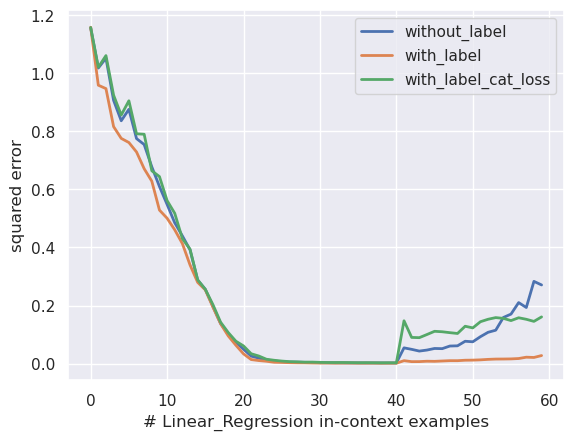

In [16]:
plt.plot(loss_without_label.mean(axis=0)/20, lw=2, label="without_label")
plt.plot(loss_with_label.mean(axis=0)/20, lw=2, label="with_label")
plt.plot(loss_with_label_cat_loss.mean(axis=0)/20, lw=2, label="with_label_cat_loss")
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# Linear_Regression in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

In [ ]:
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size  * 20

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "linear_regression",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

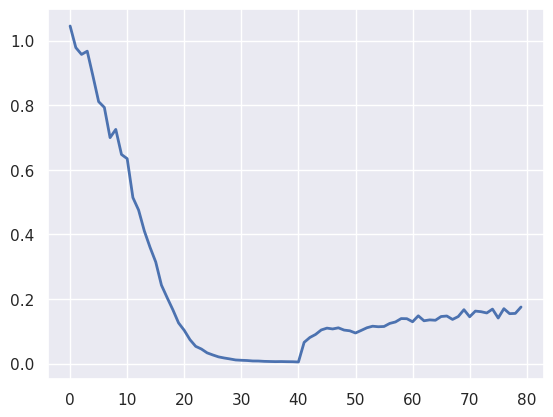

In [12]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
model_without_label = model_without_label.to(device)
task = task_sampler()

xs= data_sampler.sample_xs(b_size=batch_size, n_points=80).to(device)
ys = task.evaluate(xs).to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()



In [1]:
plt.plot(loss_without_label.mean(axis=0)/20, lw=2, label="without_label")

NameError: name 'plt' is not defined

In [17]:
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size * 20

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "quadratic_regression",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [18]:
task = task_sampler()

xs= data_sampler.sample_xs(b_size=batch_size, n_points=60).to(device)
ys = task.evaluate(xs).to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)
with torch.no_grad():
    pred_with_label = model_with_label(xs, ys,1, False)
with torch.no_grad():
    pred_with_label_cat_loss = model_with_label_cat_loss(xs, ys,1, True)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()

metric_with_label_cat_loss = task.get_metric()
loss_with_label_cat_loss = metric_with_label_cat_loss(pred_with_label_cat_loss [0], ys).cpu().numpy()

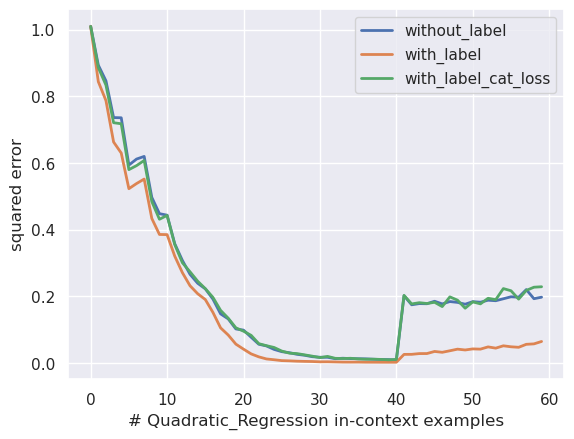

In [19]:
plt.plot(loss_without_label.mean(axis=0)/20, lw=2, label="without_label")
plt.plot(loss_with_label.mean(axis=0)/20, lw=2, label="with_label")
plt.plot(loss_with_label_cat_loss.mean(axis=0)/20, lw=2, label="with_label_cat_loss")
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# Quadratic_Regression in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

In [20]:
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size * 100

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "linear_classification",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [21]:
task = task_sampler()

xs= data_sampler.sample_xs(b_size=batch_size, n_points=60).to(device)
ys = task.evaluate(xs).to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)
with torch.no_grad():
    pred_with_label = model_with_label(xs, ys,2, False)
with torch.no_grad():
    pred_with_label_cat_loss = model_with_label_cat_loss(xs, ys,2, True)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()

metric_with_label_cat_loss = task.get_metric()
loss_with_label_cat_loss = metric_with_label_cat_loss(pred_with_label_cat_loss [0], ys).cpu().numpy()

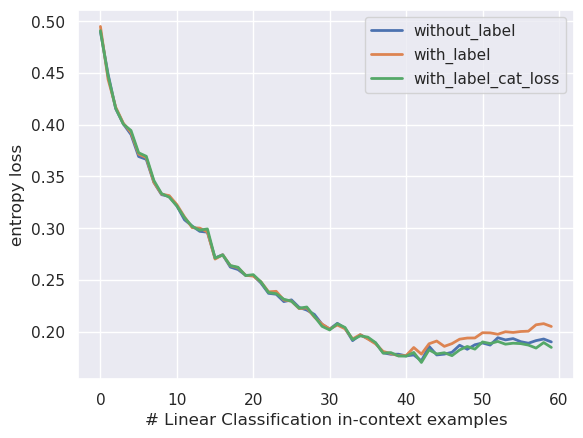

In [26]:
plt.plot(1-loss_without_label.mean(axis=0), lw=2, label="without_label")
plt.plot(1-loss_with_label.mean(axis=0), lw=2, label="with_label")
plt.plot(1-loss_with_label_cat_loss.mean(axis=0), lw=2, label="with_label_cat_loss")
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# Linear Classification in-context examples")
plt.ylabel("entropy loss")
plt.legend()
plt.show()